In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
Iris = pd.read_csv("Iris.csv")

In [8]:
data = Iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
target = Iris['Species']

In [9]:
print('Number of records: ', len(data))

Number of records:  150


In [10]:
# 检查空值：没有缺失值
data.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

In [11]:
target.isnull().sum()

0

In [12]:
# 这四个功能可能具有相同的比例
data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


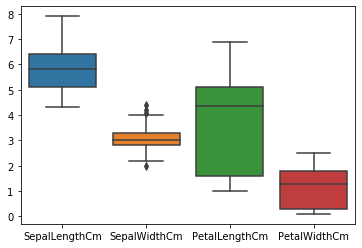

In [13]:
# 每个功能的分布
sns.boxplot(data=data)

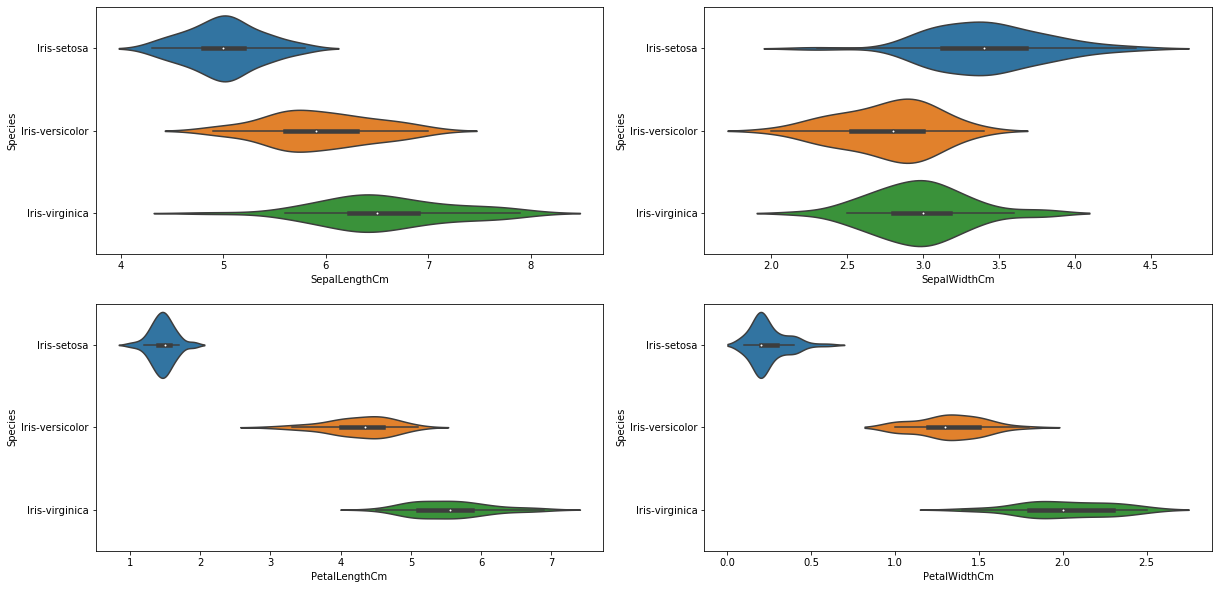

In [14]:
# 每个目标类别中每个功能的分布
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.violinplot(x=data['SepalLengthCm'], y=target)
plt.subplot(2,2,2)
sns.violinplot(x=data['SepalWidthCm'], y=target)
plt.subplot(2,2,3)
sns.violinplot(x=data['PetalLengthCm'], y=target)
plt.subplot(2,2,4)
sns.violinplot(x=data['PetalWidthCm'], y=target)

In [15]:
# 标签将目标编码为数值
le = LabelEncoder()
target_label_encoded = le.fit_transform(target)
# 创建一个临时变量以连接数据和编码目标
temp = data.copy()
temp['Species'] = target_label_encoded
temp.corr()['Species'].sort_values(ascending=False)

Species          1.000000
PetalWidthCm     0.956464
PetalLengthCm    0.949043
SepalLengthCm    0.782561
SepalWidthCm    -0.419446
Name: Species, dtype: float64

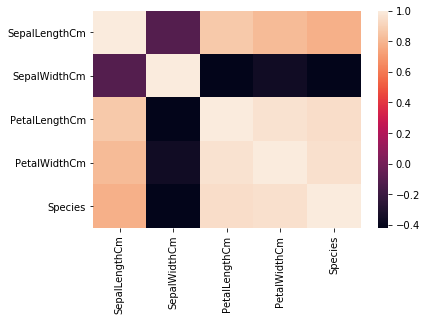

In [16]:
sns.heatmap(temp.corr())

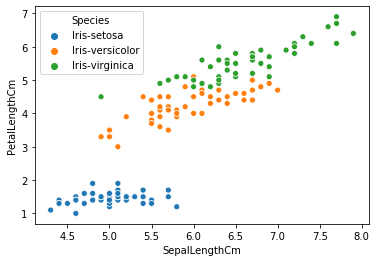

In [17]:
#2个特征的散点图 
sns.scatterplot(x=data['SepalLengthCm'], y=data['PetalLengthCm'], hue=target)

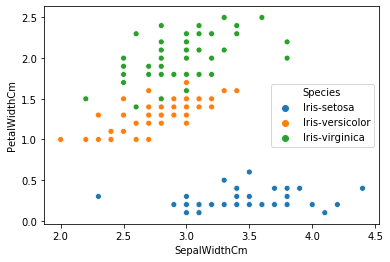

In [18]:
sns.scatterplot(x=data['SepalWidthCm'], y=data['PetalWidthCm'], hue=target)

In [19]:
# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, target_label_encoded, test_size=0.2)

In [20]:
# 创建用于训练和验证的tf数据集
# 因为tf数据集需要输入为numpy ndarray类型，所以我们需要使用.value将pandas df转换为numpy数组
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test)).batch(32)

In [21]:
# define model architecture
def build_model():
    #  我们的模型将具有1个包含4个节点的输入层，1个包含32个节点的密集层
    # 1个输出层3个节点，对应3种物种
    x = tf.keras.layers.Input(shape=(4,))
    dense1 = tf.keras.layers.Dense(32, activation='relu')(x)
    y = tf.keras.layers.Dense(3, activation='softmax')(dense1)
    model = tf.keras.models.Model(inputs=x, outputs=y)

    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 定义损失函数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# optimizer adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#包含度量值（例如损失值和准确性值）的张量
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [23]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        # 计算预测
        predictions = model(features)
        # 计算预测和目标之间的损失
        loss = loss_object(targets, predictions)
    # 使用渐变胶带跟踪渐变
    gradients = tape.gradient(loss, model.trainable_variables)
    # 使用上面计算的梯度来更新可训练的权重
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(targets, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [24]:
EPOCHS = 15
list_train_losses = []
list_train_accs = []
list_test_losses = []
list_test_accs = []

for epoch in range(EPOCHS):
    # 在下一个纪元开始时重置指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for features, targets in train_ds:
        train_step(features, targets)

    for features, targets in test_ds:
        test_step(features, targets)
    
    list_train_losses.append(train_loss.result())
    list_test_losses.append(test_loss.result())
    list_train_accs.append(train_accuracy.result())
    list_test_accs.append(test_accuracy.result())
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.9770251512527466, Accuracy: 30.83333396911621, Test Loss: 1.3156441450119019, Test Accuracy: 33.333335876464844
Epoch 2, Loss: 1.3796300888061523, Accuracy: 32.5, Test Loss: 1.2920621633529663, Test Accuracy: 33.333335876464844
Epoch 3, Loss: 1.1819391250610352, Accuracy: 34.16666793823242, Test Loss: 0.9622692465782166, Test Accuracy: 60.000003814697266
Epoch 4, Loss: 0.9557878971099854, Accuracy: 55.0, Test Loss: 0.8863904476165771, Test Accuracy: 66.66667175292969
Epoch 5, Loss: 0.85

Text(0, 0.5, 'Loss')

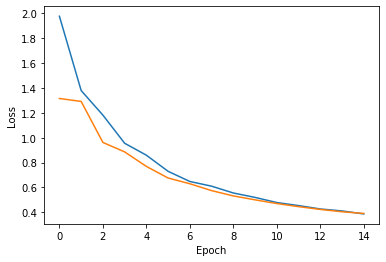

In [25]:
# 绘图训练，测试损耗曲线
plt.plot(np.arange(EPOCHS), list_train_losses)
plt.plot(np.arange(EPOCHS), list_test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

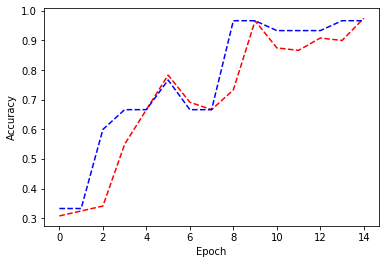

In [26]:
# 绘图训练，测试精度曲线
plt.plot(np.arange(EPOCHS), list_train_accs, 'r--')
plt.plot(np.arange(EPOCHS), list_test_accs, 'b--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')